# Cleavage heterogeneity analysis

**Description:** Analyzing drivers of different cleavage profiles, particularly high versus low entropy sites.

&rarr; Run this notebook with the `tf-train` kernel


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%run -i notebook_setup.py

Using TensorFlow backend.


## IMPORTS AND SETUP

In [4]:
import utilities
from utilities import classification_cleavage, cleavage_heterogeneity

from statsmodels.stats.multitest import multipletests
from statsmodels.stats.proportion import test_proportions_2indep


In [5]:
## specify working directories

PROJECT = "/projects/b1080/eks/polyadenylation"
DATADIR = os.path.join(PROJECT, "manuscripts", "01_development", "data")
RESDIR  = os.path.join(PROJECT, "manuscripts", "01_development", "analysis", "resources")
OUTDIR  = os.path.join(PROJECT, "manuscripts", "01_development", "figures", "Figure_03")
os.makedirs(OUTDIR, exist_ok = True)

CLVMOTDIR = os.path.join(PROJECT,'model','motif_analysis','cleavage_motifs')


## IMPORT DATA

In [6]:
all_hexamers = ["".join(x) for x in list(itertools.product('ACGT', repeat = 6))]
all_data = pd.DataFrame.from_dict({'hexamer' : all_hexamers}, orient = 'columns')

with open(os.path.join(RESDIR, 'motif_list_negative.median_then_mean.cutoff_background.pickle'), mode = 'rb') as handle:
    final_background_list = pickle.load(handle)
    
print(len(final_background_list))


2322


In [7]:
variants_patterns = ['TATAAA', 'AGTAAA', 'TTTAAA', 'AATACA', 'CATAAA', 'GATAAA', 'AATATA', 'AATGAA', 'AAGAAA']

a_patterns = ['AAAAAA','AAAAA[C|G|T]','AAAA[C|G|T]A','AAA[C|G|T]AA','AA[C|G|T]AAA','A[C|G|T]AAAA']
t_patterns = ['TTTTTT','TTTTT[A|C|G]','TTTT[A|C|G]T','TTT[A|C|G]TT','TT[A|C|G]TTT','T[A|C|G]TTTT']
g_patterns = ['GGGGGG','GGGGG[A|C|T]','GGGG[A|C|T]G','GGG[A|C|T]GG','GG[A|C|T]GGG','G[A|C|T]GGGG']

pas = [x for x in ['AATAAA','ATTAAA']+variants_patterns if x in final_background_list]
variants = [x for x in variants_patterns if x in final_background_list]
a_rich = list(set([x for x in final_background_list if (re.search("|".join(a_patterns), x) is not None) and (x not in ['AATAAA','ATTAAA'])]))
t_rich = list(set([x for x in final_background_list if (re.search("|".join(t_patterns), x) is not None)]))
g_rich = list(set([x for x in final_background_list if (re.search("|".join(g_patterns), x) is not None)]))

gt_patterns = ['GTGT','TGTG','GTCT','CTGT','TCTG','TGTC']
gt_rich = list(set([x for x in final_background_list for gt in gt_patterns if (gt in x) and ("TGTA" not in x) and ((x.count("T") >= 3) or (x.count("G") >= 3) or (x.count("C") >= 3))]))

tgta_rich = list(set([x for x in final_background_list if ("TGTA" in x)]))


In [8]:
scoring_file = os.path.join(PROJECT, "data/data_preparation/scoring_dictionary/human.exclude_4.all.adj_var.comb.filt.scoring_dictionary.pickle")
with open(scoring_file, mode = 'rb') as handle:
    reads_dict = pickle.load(handle)


In [9]:
with open(os.path.join(DATADIR, 'comprehensive_predictions', 'golden_exhaustive.with_predictions.processed.pickle'), mode = 'rb') as handle:
    golden_data = pickle.load(handle)

golden_data['pasID']              = golden_data.apply(lambda row: f'{row.name:06d}:{row.chrom}:{row.start}:{row.strand}', axis = 1)
golden_data['classificationCLIP'] = golden_data['classification'].clip(lower = 1e-6, upper = 1 - 1e-6)
golden_data['classificationLO']   = np.log2(golden_data['classificationCLIP'] / (1 - golden_data['classificationCLIP']))
golden_data['ru_overallCLIP']     = golden_data['ru_overall'].clip(lower = 1e-6, upper = 1 - 1e-6)
golden_data['ru_overallLO']       = np.log2(golden_data['ru_overallCLIP'] / (1 - golden_data['ru_overallCLIP']))

print(golden_data.shape)


(32682, 36)


In [10]:
cond1 = (golden_data['supporting_reads'] >= 100)
cond2 = (golden_data['classification'] > 0.9)
cond3 = (golden_data['cleavage_profile'].apply(lambda x : any(x > 0.02)))

gold_tpdata = golden_data.loc[cond1 & cond2 & cond3].copy()
print(gold_tpdata.shape)


(21131, 36)


## High and low entropy examples

Example of high and low entropy sites with the 3'READS data and individual renormalized cleavage vector predictions shown to illustrate difference.


In [10]:
preview_cols = ['chrom','start','strand','gene','supporting_reads','entropy_observed','entropy_redist','entropy_renorm']


#### Low entropy site in USP30

In [12]:
gold_tpdata.loc[gold_tpdata['gene'] == 'USP30', preview_cols].sort_values(['entropy_renorm']).tail(20)

,chrom,start,strand,gene,supporting_reads,entropy_observed,entropy_redist,entropy_renorm
7922,chr12,109088016,+,USP30,1203,0.141845,2.184201,1.07501


chrom                   chr12
start               109088016
strand                      +
gene                    USP30
supporting_reads         1203
entropy_observed     0.141845
entropy_redist         2.1842
entropy_renorm        1.07501
Name: 7922, dtype: object


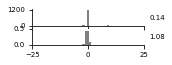

In [13]:
fig,ax = plt.subplots(2,1, figsize = (2, 0.65), sharex = True)

test_idx = 7922
test_pos = golden_data.loc[test_idx, 'start']

print(golden_data.loc[test_idx, preview_cols])

xs = np.arange(-25,25,1)
reads_vec = [reads_dict.get((golden_data.loc[test_idx, 'strand'], golden_data.loc[test_idx, 'chrom'], p), 0) for p in np.arange(test_pos-25, test_pos+25, 1)]


ax[0].bar(xs, reads_vec, color = 'gray', width = 1)
ax[0].text(x = 1.05, y = 0.5, s = round(golden_data.loc[test_idx, 'entropy_observed'],2), 
           ha = 'left', va = 'center', transform = ax[0].transAxes)

ax[0].set_xlim(-25,25)
ax[0].xaxis.set_major_locator(MultipleLocator(25))

ax[0].set_ylim(0,1205)
ax[0].yaxis.set_major_locator(MultipleLocator(1200))

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)


ax[1].bar(xs, golden_data.loc[test_idx, 'cleavage_norm'], color = 'gray', width = 1)
ax[1].text(x = 1.05, y = 0.5, s = round(golden_data.loc[test_idx, 'entropy_renorm'],2), 
           ha = 'left', va = 'center', transform = ax[1].transAxes)

ax[1].set_ylim(0,0.5)
ax[1].yaxis.set_major_locator(MultipleLocator(0.5))

ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'entropy_examples.low.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


#### High entropy site in RGMB

In [14]:
gold_tpdata.loc[gold_tpdata['gene'] == 'RGMB', preview_cols].sort_values(['entropy_renorm']).tail(20)

,chrom,start,strand,gene,supporting_reads,entropy_observed,entropy_redist,entropy_renorm
25119,chr5,98796492,+,RGMB,12960,1.053026,1.824244,1.846660
25118,chr5,98794063,+,RGMB,914,2.120370,2.410344,2.869005


chrom                   chr5
start               98794063
strand                     +
gene                    RGMB
supporting_reads         914
entropy_observed     2.12037
entropy_redist       2.41034
entropy_renorm       2.86901
Name: 25118, dtype: object


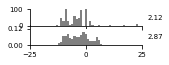

In [15]:
fig,ax = plt.subplots(2,1, figsize = (2, 0.65), sharex = True)

test_idx = 25118
test_pos = golden_data.loc[test_idx, 'start']

print(golden_data.loc[test_idx, preview_cols])

xs = np.arange(-25,25,1)
reads_vec = [reads_dict.get((golden_data.loc[test_idx, 'strand'], golden_data.loc[test_idx, 'chrom'], p), 0) for p in np.arange(test_pos-25, test_pos+25, 1)]


ax[0].bar(xs, reads_vec, color = 'gray', width = 1)
ax[0].text(x = 1.05, y = 0.5, s = round(golden_data.loc[test_idx, 'entropy_observed'],2), 
           ha = 'left', va = 'center', transform = ax[0].transAxes)

ax[0].set_xlim(-25,25)
ax[0].xaxis.set_major_locator(MultipleLocator(25))

ax[0].set_ylim(0,100)
ax[0].yaxis.set_major_locator(MultipleLocator(100))

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)


ax[1].bar(xs, golden_data.loc[test_idx, 'cleavage_norm'], color = 'gray', width = 1)
ax[1].text(x = 1.05, y = 0.5, s = round(golden_data.loc[test_idx, 'entropy_renorm'],2), 
           ha = 'left', va = 'center', transform = ax[1].transAxes)

ax[1].set_ylim(0,0.12)
ax[1].yaxis.set_major_locator(MultipleLocator(0.12))

ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'entropy_examples.high.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


#### Compare the observed and predicted cleavage vector entropy values

NA      17317
Low      2031
High     1783
Name: entropy_group, dtype: int64
1    4227
5    4226
4    4226
3    4226
2    4226
Name: entropy_observed_bins, dtype: int64


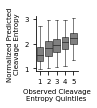

In [11]:
x = 'entropy_observed' ## observed
y = 'entropy_renorm'   ## predicted

cm_ent_lo, cm_ent_hi = np.percentile(gold_tpdata[x], [20,80])
cp_ent_lo, cp_ent_hi = np.percentile(gold_tpdata[y], [20,80])

gold_tpdata['entropy_group'] = 'NA'
gold_tpdata.loc[(gold_tpdata[x] <= cm_ent_lo) & (gold_tpdata[y] <= cp_ent_lo), 'entropy_group'] = 'Low'
gold_tpdata.loc[(gold_tpdata[x] >= cm_ent_hi) & (gold_tpdata[y] >= cp_ent_hi), 'entropy_group'] = 'High'
print(gold_tpdata['entropy_group'].value_counts())

gold_tpdata[f'{x}_bins'] = pd.qcut(gold_tpdata[x], 5, labels = [1,2,3,4,5])
gold_tpdata[f'{y}_bins'] = pd.qcut(gold_tpdata[y], 5, labels = [1,2,3,4,5])
print(gold_tpdata[f'{x}_bins'].value_counts())


fig,ax = plt.subplots(1,1, figsize = (0.75,1))

sns.boxplot(data = gold_tpdata, x = f'{x}_bins', y = y, color = 'gray',
            boxprops = {'edgecolor' : 'black', 'linewidth' : 0.5},
            medianprops = {'color' : 'black', 'linewidth' : 0.5},
            whiskerprops = {'color' : 'black', 'linewidth' : 0.5},
            capprops = {'color' : 'black', 'linewidth' : 0.5},
            flierprops = {'color' : 'black'},
            ax = ax, showfliers = False)
        
ax.set_xlabel("Observed Cleavage\nEntropy Quintiles")
ax.set_ylabel("Normalized Predicted\nCleavage Entropy")

ax.set_ylim( 0.9, 3.1)
ax.yaxis.set_major_locator(MultipleLocator(1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'entropy_boxplots.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


#### Partitioning sites into high and low entropy groups

In [12]:
cm_ent_lo, cm_ent_hi = np.percentile(gold_tpdata['entropy_observed'], [20,80])
cp_ent_lo, cp_ent_hi = np.percentile(gold_tpdata['entropy_renorm'], [20,80])

gold_tpdata['entropy_group'] = 'NA'
gold_tpdata.loc[(gold_tpdata['entropy_observed'] <= cm_ent_lo) & (gold_tpdata['entropy_renorm'] <= cp_ent_lo), 'entropy_group'] = 'Low'
gold_tpdata.loc[(gold_tpdata['entropy_observed'] >= cm_ent_hi) & (gold_tpdata['entropy_renorm'] >= cp_ent_hi), 'entropy_group'] = 'High'

print(gold_tpdata['entropy_group'].value_counts())

gold_hilo = gold_tpdata.loc[gold_tpdata['entropy_group'].isin(['Low','High']), ['pasID','entropy_group']].copy()

with open(os.path.join(CLVMOTDIR, 'cleavage_motifs.entropy_groups.v2.pickle'), mode = 'wb') as handle:
    pickle.dump(dict(zip(gold_hilo['pasID'], gold_hilo['entropy_group'])), handle)
    
print(len(dict(zip(gold_hilo['pasID'], gold_hilo['entropy_group']))))
    

NA      17317
Low      2031
High     1783
Name: entropy_group, dtype: int64
3814


#### Sites with multiple AAUAAA signals

In [13]:
gold_tpdata['count_aataaa'] = gold_tpdata.apply(lambda row: classification_cleavage.count_motifs(row['sequence'][:row['max_cleavage']], ['AATAAA'], method = 'priority', overlapping = False, preference = 'max', count_only = True), axis = 1)
gold_tpdata['multiple_aataaa'] = (gold_tpdata['count_aataaa'] > 1)

print("AATAAA\tCount\tFraction")
for z in zip(gold_tpdata['count_aataaa'].value_counts(sort = False).index, gold_tpdata['count_aataaa'].value_counts(sort = False).values, gold_tpdata['count_aataaa'].value_counts(sort = False) / len(gold_tpdata)):
    print("\t".join([str(_) for _ in z]))


AATAAA	Count	Fraction
0	2473	0.11703184894231224
1	17152	0.8116984525105295
2	1416	0.06701055321565473
3	80	0.0037859069613364253
4	7	0.0003312668591169372
5	3	0.00014197151105011595


In [14]:
aataaa_counts = (gold_tpdata.loc[gold_tpdata['entropy_group'] != 'NA']
                 .groupby(['entropy_group','count_aataaa']).size()
                 .reset_index().rename(columns = {0 : 'count'}))

aataaa_counts['prop'] = aataaa_counts['count'] / aataaa_counts.groupby('entropy_group')['count'].transform('sum')

aataaa_counts


,entropy_group,count_aataaa,count,prop
0,High,0,185,0.103758
1,High,1,1383,0.775659
2,High,2,198,0.111049
3,High,3,13,0.007291
4,High,4,3,0.001683
5,High,5,1,0.000561
6,Low,0,252,0.124077
7,Low,1,1687,0.830625
8,Low,2,89,0.043821
9,Low,3,3,0.001477


In [18]:
# gold_tpdata['aataaa_idx'] = gold_tpdata.apply(lambda row: classification_cleavage.count_motifs(row['sequence'][:row['max_cleavage']], ['AATAAA'], method = 'priority', overlapping = False, preference = 'max', count_only = False, index_only = True), axis = 1)
gold_tpdata['aataaa_dist'] = gold_tpdata['aataaa_idx'].apply(lambda x : np.abs(np.max(x) - np.min(x)) if (len(x)) else np.nan)


In [30]:
gold_tpdata.loc[gold_tpdata['count_aataaa'] == 2, 'aataaa_dist'].describe()

count    1416.000000
mean       45.153955
std        28.226174
min         6.000000
25%        18.000000
50%        43.000000
75%        69.000000
max       107.000000
Name: aataaa_dist, dtype: float64

#### Characterizing high and low entropy sites by motifs present

In [19]:
groups = 'entropy_group'
gold_ent_data = gold_tpdata.loc[gold_tpdata[groups] != 'NA'].copy()
print(gold_ent_data.entropy_group.value_counts())


Low     2031
High    1783
Name: entropy_group, dtype: int64


               multiple_aataaa  count       prop
entropy_group                                   
High                     215.0   1783  12.058329
Low                       92.0   2031   4.529788


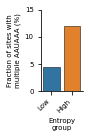

Hypothesis test comparing two independent proportions, two-sided, assuming binomial samples:
statistic = 8.359459237001975
pvalue = 6.300639107554736e-17
compare = diff
method = agresti-caffo
diff = 0.07528540377927873
ratio = 2.6620071203882074
odds_ratio = 2.8898971273291925
variance = 8.106044457565763e-05
alternative = two-sided
value = 0
tuple = (8.359459237001975, 6.300639107554736e-17)
               multiple_aataaa  count       prop
entropy_group                                   
High                     215.0   1783  12.058329
Low                       92.0   2031   4.529788


In [20]:
gold_ent_data['count_aataaa'] = gold_ent_data.apply(lambda row: classification_cleavage.count_motifs(row['sequence'][:row['max_cleavage']], ['AATAAA'], method = 'priority', overlapping = False, preference = 'max', count_only = True), axis = 1)
gold_ent_data['multiple_aataaa'] = (gold_ent_data['count_aataaa'] > 1)

gold_aataaa_sum = gold_ent_data[['entropy_group', 'multiple_aataaa']].groupby('entropy_group').agg('sum')
gold_aataaa_sum['count'] = gold_ent_data.groupby('entropy_group').size()
gold_aataaa_sum['prop'] = gold_aataaa_sum['multiple_aataaa'] / gold_aataaa_sum['count'] * 100
print(gold_aataaa_sum)


fig,ax = plt.subplots(1,1, figsize = (0.75,1.5))

sns.barplot(data = gold_aataaa_sum.reset_index(), 
            x = 'entropy_group', y = 'prop', order = ['Low','High'],
            hue = 'entropy_group', hue_order = ['Low','High'], 
            dodge = False, edgecolor = 'black',
            linewidth = 0.5)

ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right')

ax.set_xlabel("Entropy\ngroup")
ax.set_ylabel("Fraction of sites with\nmultiple AAUAAA (%)")
ax.set_ylim(0,15)

ax.yaxis.set_major_locator(MultipleLocator(5))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.get_legend().remove()

plt.savefig(os.path.join(OUTDIR, 'upstream_multiple_aataaa_prop.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()



## test difference in proportions in region

prop_test = test_proportions_2indep(count1 = gold_aataaa_sum.loc['High', 'multiple_aataaa'], nobs1 = gold_aataaa_sum.loc['High', 'count'],
                                    count2 = gold_aataaa_sum.loc['Low',  'multiple_aataaa'], nobs2 = gold_aataaa_sum.loc['Low',  'count'])

print("Hypothesis test comparing two independent proportions, two-sided, assuming binomial samples:")
print(prop_test)
print(gold_aataaa_sum)


               multiple_attaaa  count      prop
entropy_group                                  
High                      18.0   1783  1.009534
Low                       16.0   2031  0.787789


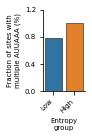

Hypothesis test comparing two independent proportions, two-sided, assuming binomial samples:
statistic = 0.7224838168260356
pvalue = 0.46999707148619374
compare = diff
method = agresti-caffo
diff = 0.002217452260572456
ratio = 1.281477846326416
odds_ratio = 1.2843484419263456
variance = 9.978448194471006e-06
alternative = two-sided
value = 0
tuple = (0.7224838168260356, 0.46999707148619374)
               multiple_attaaa  count      prop
entropy_group                                  
High                      18.0   1783  1.009534
Low                       16.0   2031  0.787789


In [21]:
gold_ent_data['count_attaaa'] = gold_ent_data.apply(lambda row: classification_cleavage.count_motifs(row['sequence'][:row['max_cleavage']], ['ATTAAA'], method = 'priority', overlapping = False, preference = 'max', count_only = True), axis = 1)
gold_ent_data['multiple_attaaa'] = (gold_ent_data['count_attaaa'] > 1)

gold_attaaa_sum = gold_ent_data[['entropy_group', 'multiple_attaaa']].groupby('entropy_group').agg('sum')
gold_attaaa_sum['count'] = gold_ent_data.groupby('entropy_group').size()
gold_attaaa_sum['prop'] = gold_attaaa_sum['multiple_attaaa'] / gold_attaaa_sum['count'] * 100
print(gold_attaaa_sum)


fig,ax = plt.subplots(1,1, figsize = (0.75,1.5))

sns.barplot(data = gold_attaaa_sum.reset_index(), 
            x = 'entropy_group', y = 'prop', order = ['Low','High'],
            hue = 'entropy_group', hue_order = ['Low','High'], 
            dodge = False, edgecolor = 'black',
            linewidth = 0.5)

ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right')

ax.set_xlabel("Entropy\ngroup")
ax.set_ylabel("Fraction of sites with\nmultiple AUUAAA (%)")
ax.set_ylim(0,1.2)

ax.yaxis.set_major_locator(MultipleLocator(0.4))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.get_legend().remove()

plt.savefig(os.path.join(OUTDIR, 'upstream_multiple_attaaa_prop.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()



## test difference in proportions in region

prop_test = test_proportions_2indep(count1 = gold_attaaa_sum.loc['High', 'multiple_attaaa'], nobs1 = gold_attaaa_sum.loc['High', 'count'],
                                    count2 = gold_attaaa_sum.loc['Low',  'multiple_attaaa'], nobs2 = gold_attaaa_sum.loc['Low',  'count'])

print("Hypothesis test comparing two independent proportions, two-sided, assuming binomial samples:")
print(prop_test)
print(gold_attaaa_sum)


               multiple_variants  count       prop
entropy_group                                     
High                       307.0   1783  17.218172
Low                        371.0   2031  18.266864


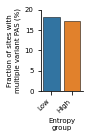

Hypothesis test comparing two independent proportions, two-sided, assuming binomial samples:
statistic = -0.8419242918438303
pvalue = 0.39983033209024677
compare = diff
method = agresti-caffo
diff = -0.010486919931195465
ratio = 0.9425904733685768
odds_ratio = 0.9306496029919867
variance = 0.00015352254707931106
alternative = two-sided
value = 0
tuple = (-0.8419242918438303, 0.39983033209024677)
               multiple_attaaa  count      prop
entropy_group                                  
High                      18.0   1783  1.009534
Low                       16.0   2031  0.787789


In [22]:
gold_ent_data['count_variants'] = gold_ent_data.apply(lambda row: classification_cleavage.count_motifs(row['sequence'][:row['max_cleavage']], variants, method = 'priority', overlapping = False, preference = 'max', count_only = True), axis = 1)
gold_ent_data['multiple_variants'] = (gold_ent_data['count_variants'] > 1)

gold_variant_sum = gold_ent_data[['entropy_group', 'multiple_variants']].groupby('entropy_group').agg('sum')
gold_variant_sum['count'] = gold_ent_data.groupby('entropy_group').size()
gold_variant_sum['prop'] = gold_variant_sum['multiple_variants'] / gold_variant_sum['count'] * 100
print(gold_variant_sum)


fig,ax = plt.subplots(1,1, figsize = (0.75,1.5))

sns.barplot(data = gold_variant_sum.reset_index(), 
            x = 'entropy_group', y = 'prop', order = ['Low','High'],
            hue = 'entropy_group', hue_order = ['Low','High'], 
            dodge = False, edgecolor = 'black',
            linewidth = 0.5)

ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right')

ax.set_xlabel("Entropy\ngroup")
ax.set_ylabel("Fraction of sites with\nmultiple variant PAS (%)")
ax.set_ylim(0,20)

ax.yaxis.set_major_locator(MultipleLocator(5))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.get_legend().remove()

plt.savefig(os.path.join(OUTDIR, 'upstream_multiple_variant_prop.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()



## test difference in proportions in region

prop_test = test_proportions_2indep(count1 = gold_variant_sum.loc['High', 'multiple_variants'], nobs1 = gold_variant_sum.loc['High', 'count'],
                                    count2 = gold_variant_sum.loc['Low',  'multiple_variants'], nobs2 = gold_variant_sum.loc['Low',  'count'])

print("Hypothesis test comparing two independent proportions, two-sided, assuming binomial samples:")
print(prop_test)
print(gold_attaaa_sum)


               multiple_arich  count       prop
entropy_group                                  
High                    727.0   1783  40.773976
Low                     737.0   2031  36.287543


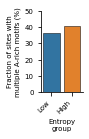

Hypothesis test comparing two independent proportions, two-sided, assuming binomial samples:
statistic = 2.840945240088234
pvalue = 0.004498003528199852
compare = diff
method = agresti-caffo
diff = 0.04486433361969672
ratio = 1.1236356330822308
odds_ratio = 1.208752210024259
variance = 0.00024903830409186994
alternative = two-sided
value = 0
tuple = (2.840945240088234, 0.004498003528199852)
               multiple_arich  count       prop
entropy_group                                  
High                    727.0   1783  40.773976
Low                     737.0   2031  36.287543


In [23]:
gold_ent_data['count_arich']  = gold_ent_data.apply(lambda row: classification_cleavage.count_motifs(row['sequence'][:row['max_cleavage']], a_rich,  method = 'sequential', overlapping = False, preference = 'max', count_only = True), axis = 1)
gold_ent_data['multiple_arich'] = (gold_ent_data['count_arich'] > 1)

gold_arich_sum = gold_ent_data[['entropy_group', 'multiple_arich']].groupby('entropy_group').agg('sum')
gold_arich_sum['count'] = gold_ent_data.groupby('entropy_group').size()
gold_arich_sum['prop'] = gold_arich_sum['multiple_arich'] / gold_arich_sum['count'] * 100
print(gold_arich_sum)


fig,ax = plt.subplots(1,1, figsize = (0.75,1.5))

sns.barplot(data = gold_arich_sum.reset_index(), 
            x = 'entropy_group', y = 'prop', order = ['Low','High'],
            hue = 'entropy_group', hue_order = ['Low','High'], 
            dodge = False, edgecolor = 'black',
            linewidth = 0.5)

ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right')

ax.set_xlabel("Entropy\ngroup")
ax.set_ylabel("Fraction of sites with\nmultiple A-rich motifs (%)")
ax.set_ylim(0,50)

ax.yaxis.set_major_locator(MultipleLocator(10))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.get_legend().remove()

plt.savefig(os.path.join(OUTDIR, 'upstream_multiple_arich_prop.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()



## test difference in proportions in region

prop_test = test_proportions_2indep(count1 = gold_arich_sum.loc['High', 'multiple_arich'], nobs1 = gold_arich_sum.loc['High', 'count'],
                                    count2 = gold_arich_sum.loc['Low',  'multiple_arich'], nobs2 = gold_arich_sum.loc['Low',  'count'])

print("Hypothesis test comparing two independent proportions, two-sided, assuming binomial samples:")
print(prop_test)
print(gold_arich_sum)


               multiple_pas  count       prop
entropy_group                                
High                  981.0   1783  55.019630
Low                  1007.0   2031  49.581487


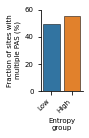

Hypothesis test comparing two independent proportions, two-sided, assuming binomial samples:
statistic = 3.358467517698506
pvalue = 0.0007837593195968228
compare = diff
method = agresti-caffo
diff = 0.05438142885112501
ratio = 1.1096809155875222
odds_ratio = 1.243841736275003
variance = 0.0002616099852091278
alternative = two-sided
value = 0
tuple = (3.358467517698506, 0.0007837593195968228)
               multiple_pas  count       prop
entropy_group                                
High                  981.0   1783  55.019630
Low                  1007.0   2031  49.581487


In [52]:
gold_ent_data['count_pas'] = gold_ent_data.apply(lambda row: classification_cleavage.count_motifs(row['sequence'][:row['max_cleavage']], ['AATAAA','ATTAAA']+variants, method = 'priority', overlapping = False, preference = 'max', count_only = True), axis = 1)
gold_ent_data['multiple_pas'] = (gold_ent_data['count_pas'] > 1)

gold_pas_sum = gold_ent_data[['entropy_group', 'multiple_pas']].groupby('entropy_group').agg('sum')
gold_pas_sum['count'] = gold_ent_data.groupby('entropy_group').size()
gold_pas_sum['prop'] = gold_pas_sum['multiple_pas'] / gold_pas_sum['count'] * 100
print(gold_pas_sum)


fig,ax = plt.subplots(1,1, figsize = (0.75,1.5))

sns.barplot(data = gold_pas_sum.reset_index(), 
            x = 'entropy_group', y = 'prop', order = ['Low','High'],
            hue = 'entropy_group', hue_order = ['Low','High'], 
            dodge = False, edgecolor = 'black',
            linewidth = 0.5)

ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right')

ax.set_xlabel("Entropy\ngroup")
ax.set_ylabel("Fraction of sites with\nmultiple PAS (%)")
ax.set_ylim(0,60)

ax.yaxis.set_major_locator(MultipleLocator(20))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.get_legend().remove()

plt.savefig(os.path.join(OUTDIR, 'upstream_multiple_pas_prop.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()



## test difference in proportions in region

prop_test = test_proportions_2indep(count1 = gold_pas_sum.loc['High', 'multiple_pas'], nobs1 = gold_pas_sum.loc['High', 'count'],
                                    count2 = gold_pas_sum.loc['Low',  'multiple_pas'], nobs2 = gold_pas_sum.loc['Low',  'count'])

print("Hypothesis test comparing two independent proportions, two-sided, assuming binomial samples:")
print(prop_test)
print(gold_pas_sum)


               multiple_trich  count       prop
entropy_group                                  
High                    791.0   1783  44.363432
Low                     867.0   2031  42.688331


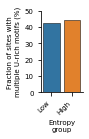

Hypothesis test comparing two independent proportions, two-sided, assuming binomial samples:
statistic = 1.0410628402354205
pvalue = 0.2978463843538085
compare = diff
method = agresti-caffo
diff = 0.016751015457823815
ratio = 1.0392402680447983
odds_ratio = 1.0705296350039066
variance = 0.00025862664061586296
alternative = two-sided
value = 0
tuple = (1.0410628402354205, 0.2978463843538085)
               multiple_trich  count       prop
entropy_group                                  
High                    791.0   1783  44.363432
Low                     867.0   2031  42.688331


In [25]:
gold_ent_data['count_trich']  = gold_ent_data.apply(lambda row: classification_cleavage.count_motifs(row['sequence'][row['max_cleavage']:], t_rich,  method = 'sequential', overlapping = False, preference = 'min', count_only = True), axis = 1)
gold_ent_data['multiple_trich'] = (gold_ent_data['count_trich'] > 1)

gold_trich_sum = gold_ent_data[['entropy_group', 'multiple_trich']].groupby('entropy_group').agg('sum')
gold_trich_sum['count'] = gold_ent_data.groupby('entropy_group').size()
gold_trich_sum['prop'] = gold_trich_sum['multiple_trich'] / gold_trich_sum['count'] * 100
print(gold_trich_sum)


fig,ax = plt.subplots(1,1, figsize = (0.75,1.5))

sns.barplot(data = gold_trich_sum.reset_index(), 
            x = 'entropy_group', y = 'prop', order = ['Low','High'],
            hue = 'entropy_group', hue_order = ['Low','High'], 
            dodge = False, edgecolor = 'black',
            linewidth = 0.5)

ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right')

ax.set_xlabel("Entropy\ngroup")
ax.set_ylabel("Fraction of sites with\nmultiple U-rich motifs (%)")
ax.set_ylim(0,50)

ax.yaxis.set_major_locator(MultipleLocator(10))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.get_legend().remove()

plt.savefig(os.path.join(OUTDIR, 'upstream_multiple_trich_prop.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()



## test difference in proportions in region

prop_test = test_proportions_2indep(count1 = gold_trich_sum.loc['High', 'multiple_trich'], nobs1 = gold_trich_sum.loc['High', 'count'],
                                    count2 = gold_trich_sum.loc['Low',  'multiple_trich'], nobs2 = gold_trich_sum.loc['Low',  'count'])

print("Hypothesis test comparing two independent proportions, two-sided, assuming binomial samples:")
print(prop_test)
print(gold_trich_sum)


               multiple_gtrich  count       prop
entropy_group                                   
High                    1231.0   1783  69.040942
Low                     1412.0   2031  69.522403


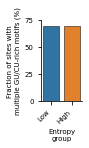

Hypothesis test comparing two independent proportions, two-sided, assuming binomial samples:
statistic = -0.3230748917160838
pvalue = 0.7466385249875609
compare = diff
method = agresti-caffo
diff = -0.004814605250694992
ratio = 0.9930747427307638
odds_ratio = 0.9776309171901301
variance = 0.00022405112808339896
alternative = two-sided
value = 0
tuple = (-0.3230748917160838, 0.7466385249875609)
               multiple_gtrich  count       prop
entropy_group                                   
High                    1231.0   1783  69.040942
Low                     1412.0   2031  69.522403


In [26]:
gold_ent_data['count_gtrich'] = gold_ent_data.apply(lambda row: classification_cleavage.count_motifs(row['sequence'][row['max_cleavage']:], gt_rich, method = 'sequential', overlapping = False, preference = 'min', count_only = True), axis = 1)
gold_ent_data['multiple_gtrich'] = (gold_ent_data['count_gtrich'] > 1)

gold_gtrich_sum = gold_ent_data[['entropy_group', 'multiple_gtrich']].groupby('entropy_group').agg('sum')
gold_gtrich_sum['count'] = gold_ent_data.groupby('entropy_group').size()
gold_gtrich_sum['prop'] = gold_gtrich_sum['multiple_gtrich'] / gold_gtrich_sum['count'] * 100
print(gold_gtrich_sum)


fig,ax = plt.subplots(1,1, figsize = (0.75,1.5))

sns.barplot(data = gold_gtrich_sum.reset_index(), 
            x = 'entropy_group', y = 'prop', order = ['Low','High'],
            hue = 'entropy_group', hue_order = ['Low','High'], 
            dodge = False, edgecolor = 'black',
            linewidth = 0.5)

ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right')

ax.set_xlabel("Entropy\ngroup")
ax.set_ylabel("Fraction of sites with\nmultiple GU/CU-rich motifs (%)")
ax.set_ylim(0,75)

ax.yaxis.set_major_locator(MultipleLocator(25))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.get_legend().remove()

plt.savefig(os.path.join(OUTDIR, 'upstream_multiple_gtrich_prop.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()



## test difference in proportions in region

prop_test = test_proportions_2indep(count1 = gold_gtrich_sum.loc['High', 'multiple_gtrich'], nobs1 = gold_gtrich_sum.loc['High', 'count'],
                                    count2 = gold_gtrich_sum.loc['Low',  'multiple_gtrich'], nobs2 = gold_gtrich_sum.loc['Low',  'count'])

print("Hypothesis test comparing two independent proportions, two-sided, assuming binomial samples:")
print(prop_test)
print(gold_gtrich_sum)


               multiple_grich  count      prop
entropy_group                                 
High                    161.0   1783  9.029725
Low                     200.0   2031  9.847366


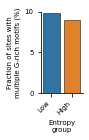

Hypothesis test comparing two independent proportions, two-sided, assuming binomial samples:
statistic = -0.854865671441338
pvalue = 0.3926255169804663
compare = diff
method = agresti-caffo
diff = -0.0081764064736351
ratio = 0.9169685922602355
odds_ratio = 0.9087268803945746
variance = 9.005320079721147e-05
alternative = two-sided
value = 0
tuple = (-0.854865671441338, 0.3926255169804663)
               multiple_grich  count      prop
entropy_group                                 
High                    161.0   1783  9.029725
Low                     200.0   2031  9.847366


In [51]:
gold_ent_data['count_grich'] = gold_ent_data.apply(lambda row: classification_cleavage.count_motifs(row['sequence'][row['max_cleavage']:], g_rich, method = 'sequential', overlapping = False, preference = 'min', count_only = True), axis = 1)
gold_ent_data['multiple_grich'] = (gold_ent_data['count_grich'] > 1)

gold_grich_sum = gold_ent_data[['entropy_group', 'multiple_grich']].groupby('entropy_group').agg('sum')
gold_grich_sum['count'] = gold_ent_data.groupby('entropy_group').size()
gold_grich_sum['prop'] = gold_grich_sum['multiple_grich'] / gold_grich_sum['count'] * 100
print(gold_grich_sum)


fig,ax = plt.subplots(1,1, figsize = (0.75,1.5))

sns.barplot(data = gold_grich_sum.reset_index(), 
            x = 'entropy_group', y = 'prop', order = ['Low','High'],
            hue = 'entropy_group', hue_order = ['Low','High'], 
            dodge = False, edgecolor = 'black',
            linewidth = 0.5)

ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right')

ax.set_xlabel("Entropy\ngroup")
ax.set_ylabel("Fraction of sites with\nmultiple G-rich motifs (%)")
ax.set_ylim(0,10)

ax.yaxis.set_major_locator(MultipleLocator(5))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.get_legend().remove()

plt.savefig(os.path.join(OUTDIR, 'upstream_multiple_grich_prop.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()



## test difference in proportions in region

prop_test = test_proportions_2indep(count1 = gold_grich_sum.loc['High', 'multiple_grich'], nobs1 = gold_grich_sum.loc['High', 'count'],
                                    count2 = gold_grich_sum.loc['Low',  'multiple_grich'], nobs2 = gold_grich_sum.loc['Low',  'count'])

print("Hypothesis test comparing two independent proportions, two-sided, assuming binomial samples:")
print(prop_test)
print(gold_grich_sum)


#### Splitting sites by entropy and the presence of multiple AAUAAA signals

In [28]:
gold_ent_data['category_aataaa'] = 'NA'

gold_ent_data.loc[gold_ent_data['entropy_group'] == 'Low', 'category_aataaa'] = 'Low'
gold_ent_data.loc[(gold_ent_data['entropy_group'] == 'High') & (gold_ent_data['count_aataaa'] == 0), 'category_aataaa'] = 'High_none'
gold_ent_data.loc[(gold_ent_data['entropy_group'] == 'High') & (gold_ent_data['count_aataaa'] == 1), 'category_aataaa'] = 'High_single'
gold_ent_data.loc[(gold_ent_data['entropy_group'] == 'High') & (gold_ent_data['count_aataaa'] > 1), 'category_aataaa'] = 'High_multiple'

gold_ent_data['category_aataaa'].value_counts()


Low              2031
High_single      1383
High_multiple     215
High_none         185
Name: category_aataaa, dtype: int64

In [29]:
gold_ent_data['category_aataaa'] = 'NA'

gold_ent_data.loc[gold_ent_data['entropy_group'] == 'Low', 'category_aataaa'] = 'Low'
gold_ent_data.loc[(gold_ent_data['entropy_group'] == 'High') & (gold_ent_data['count_aataaa'] == 0), 'category_aataaa'] = 'High_none'
gold_ent_data.loc[(gold_ent_data['entropy_group'] == 'High') & (gold_ent_data['count_aataaa'] == 1), 'category_aataaa'] = 'High_single'
gold_ent_data.loc[(gold_ent_data['entropy_group'] == 'High') & (gold_ent_data['count_aataaa'] > 1), 'category_aataaa'] = 'High_multiple'

gold_ent_data['category_aataaa'].value_counts()


Low              2031
High_single      1383
High_multiple     215
High_none         185
Name: category_aataaa, dtype: int64

#### PolyaID classification by entropy group

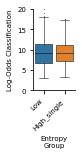

Corresponding statistics:
Low vs High (single)-	 RanksumsResult(statistic=-0.6681303115930599, pvalue=0.5040504146004375)


In [30]:
fig,ax = plt.subplots(1,1, figsize = (0.75,1.5))

sns.boxplot(data = gold_ent_data, x = 'category_aataaa', y = 'classificationLO', 
            order = ['Low','High_single'],
            fliersize = 0.2,
            boxprops = {'edgecolor' : 'black', 'linewidth' : 0.5},
            medianprops = {'color' : 'black', 'linewidth' : 0.5},
            whiskerprops = {'color' : 'black', 'linewidth' : 0.5},
            capprops = {'color' : 'black', 'linewidth' : 0.5},
            flierprops = {'color' : 'black'},
            ax = ax)

ax.set_xlabel("Entropy\nGroup")
ax.set_ylabel("Log-Odds Classification")

ax.set_ylim((0,20))

ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'classification_logodds_boxplot.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding statistics:")
print("Low vs High (single)-\t",
      st.ranksums(gold_ent_data.loc[gold_ent_data['category_aataaa'] == 'Low', 'classificationLO'],
                  gold_ent_data.loc[gold_ent_data['category_aataaa'] == 'High_single', 'classificationLO']))


#### PolyaStrength score by entropy group

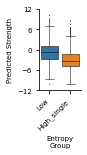

Corresponding statistics:
Low vs High (single)-	 RanksumsResult(statistic=21.27662568896687, pvalue=1.86920196365014e-100)


In [31]:
fig,ax = plt.subplots(1,1, figsize = (0.75,1.5))

sns.boxplot(data = gold_ent_data, x = 'category_aataaa', y = 'strength', 
            order = ['Low','High_single'],
            fliersize = 0.2,
            boxprops = {'edgecolor' : 'black', 'linewidth' : 0.5},
            medianprops = {'color' : 'black', 'linewidth' : 0.5},
            whiskerprops = {'color' : 'black', 'linewidth' : 0.5},
            capprops = {'color' : 'black', 'linewidth' : 0.5},
            flierprops = {'color' : 'black'},
            ax = ax)

ax.set_xlabel("Entropy\nGroup")
ax.set_ylabel("Predicted Strength")

ax.set_ylim((-12,12))
ax.yaxis.set_major_locator(MultipleLocator(6))

ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'strength_boxplot.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding statistics:")
print("Low vs High (single)-\t",
      st.ranksums(gold_ent_data.loc[gold_ent_data['category_aataaa'] == 'Low', 'strength'],
                  gold_ent_data.loc[gold_ent_data['category_aataaa'] == 'High_single', 'strength']))


### Motif Enrichment by Region

#### Prepare Data for Enrichment

In [32]:
gold_hilo_single = gold_ent_data.loc[gold_ent_data['count_aataaa'] == 1, ['pasID','entropy_group']].copy()
print(gold_hilo_single.entropy_group.value_counts())

with open(os.path.join(PROJECT,'model','motif_analysis','cleavage_motifs','cleavage_motifs.single.entropy_groups.v2.pickle'), mode = 'wb') as handle:
    pickle.dump(dict(zip(gold_hilo_single['pasID'], gold_hilo_single['entropy_group'])), handle)
    
print(len(dict(zip(gold_hilo_single['pasID'], gold_hilo_single['entropy_group']))))
    

Low     1687
High    1383
Name: entropy_group, dtype: int64
3070


#### Enrichment Results


Region: (-120, -30)


/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


     testMotif  odds_ratio_log2  pvalue_minlog10        qvalue
9       AATAAA         5.450367        88.986007  4.225994e-86
224     AAATAA         1.760402        24.198217  1.296250e-21
58      CAATAA         2.611538        18.504153  4.272296e-16
578     TAATAA         1.884156        17.086309  8.386234e-15
463     ATAAAT         1.259074         9.101635  6.476351e-07
1229    GAATAA         1.497863         8.703409  1.341600e-06
39      ATAAAA         1.094703         8.639214  1.341600e-06
258     ATAAAG         1.258760         6.219031  3.088976e-04
2376    TCAATA         1.347922         5.544374  1.298134e-03
1482    TAAATA         0.773075         5.231868  2.399205e-03
2340    ATAAAC         1.248329         4.676349  7.837791e-03
1334    ATTAAA         0.796123         4.393408  1.378308e-02
2069    ATAATA         0.928141         4.030075  2.937093e-02
1729    AAAATA         0.558566         3.302967  1.454924e-01
1662    CTAATA         1.229928         3.241653  1.563

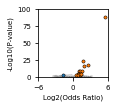

/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)



Region: (-30, 0)
     testMotif  odds_ratio_log2  pvalue_minlog10    qvalue
212     TTTAAA        -1.195133         9.424109  0.000001
989     CTTAAT        -1.924299         6.460617  0.000676
58      CAATAA        -0.586586         6.120779  0.000790
1770    CTAAAA        -2.352014         6.092027  0.000790
9       AATAAA        -0.258072         5.401544  0.003098
1056    TTAAAA        -0.893871         5.169944  0.004401
154     TAAACT        -1.005917         4.983553  0.005794
578     TAATAA        -0.482480         4.820852  0.007374
1072    TTTTAA        -0.784471         4.726852  0.008138
1804    TGAAAC        -2.640221         4.674851  0.008256
49      ATGTGT         1.872576         4.578881  0.009362
2376    TCAATA        -0.792436         4.346907  0.014640
1400    TCTAAA        -1.458679         4.253053  0.016774
3       AAACTT        -0.993208         4.139633  0.020224
2077    CAAACT        -2.714090         4.063451  0.022495
424     TGTGTC         2.346228       

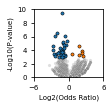

/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)



Region: (0, 30)
     testMotif  odds_ratio_log2  pvalue_minlog10    qvalue
1297    AAAAAA        -1.037961         7.048985  0.000356
149     GTGTCT        -1.299582         4.222250  0.119350
1728    AAAAAT        -0.954651         3.820408  0.191998
2239    GAAATT         1.828001         3.697942  0.191998
1078    TTTTTT        -0.392212         3.617834  0.191998
1731    AAACTG        -1.714185         3.495992  0.197737
2791    ATATAT         1.208236         3.458915  0.197737
1092    ACAAAT         1.823412         3.362869  0.215845
424     TGTGTC        -1.074353         3.237743  0.248317
1002    GCAGCA         2.535115         3.189365  0.248317
632     ATGAAA         1.772752         3.148433  0.248317
2627    GAAAAT         1.931136         3.125914  0.248317
239     AGAAAT         1.685881         3.063248  0.264795
622     AGCATG         2.003447         3.011096  0.277254


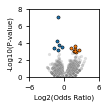

/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)



Region: (30, 120)
     testMotif  odds_ratio_log2  pvalue_minlog10    qvalue
206     TTATTT         0.730220         5.512453  0.012568
972     CAGATA        -1.712751         4.364993  0.088247
2284    AGCTGG        -1.172222         3.641000  0.244806
1261    TATATA         0.752187         3.620842  0.244806
823     CTTTTC         0.787290         3.473290  0.270639
1160    TATTTT         0.539947         3.401182  0.270639
219     TTTTAT         0.590587         3.287273  0.271793
307     CGGGGA        -1.882548         3.216989  0.271793
1075    TTTTGT         0.559634         3.199369  0.271793
2791    ATATAT         0.683503         3.150458  0.271793
1269    TCTGTC         0.988477         3.136092  0.271793


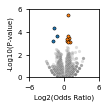

In [33]:
region_results = []
regions = [(-120,-30), (-30,0), (0,30), (30,120)]
label_threshs = [99.95, 99.95, 99.99, 99.99]
ylims = [100,10,8,6]
yints = [25,2,2,2]
group = 'entropy'
kmer = 6

for region,label_thresh,ylim_up,yint_up in zip(regions,label_threshs,ylims,yints):

    dt = pd.read_csv(os.path.join(CLVMOTDIR, f'cleavage_motifs.{kmer}mers.redist.{group}_groups.enrichment_{region[0]}_{region[1]}.txt'), sep = "\t")
    dt = dt.dropna()
    
    dt['odds_ratio_log2'] = -1 * np.log2(dt['odds_ratio'])
    dt['pvalue_minlog10'] = -1 * np.log10(dt['pvalue'])
    
    dt['qvalue'] = multipletests(dt['pvalue'], alpha = 0.05, method = 'fdr_bh')[1]
    dt['qvalue_minlog10']  = -1 * np.log10(dt['qvalue'])
    
    region_results.append(dt)
    
    
    ## make plot
    
    fig,ax = plt.subplots(1,1, figsize = (1.25,1.25))
    
    sns.scatterplot(data = dt,  x = 'odds_ratio_log2', y = 'pvalue_minlog10', 
                    s = 10, color = 'gray', alpha = 0.25, rasterized = True,
                    ax = ax)
    
    ax.set_xlim((-6,6))
    ax.set_xticks(np.arange(-6,7,6))
    ax.set_ylim((0,ylim_up))
    ax.set_yticks(np.arange(0,ylim_up+1,yint_up))
    
    ax.set_xlabel("Log2(Odds Ratio)")
    ax.set_ylabel("-Log10(P-value)")

    ## annotate plots
    
    print("\nRegion:", region)
    print(dt.loc[dt['pvalue'] < 0.001, ['testMotif','odds_ratio_log2', 'pvalue_minlog10', 'qvalue']].sort_values('pvalue_minlog10', ascending = False))
    
    for i,dtrow in dt.loc[dt['pvalue'] < 0.001].iterrows():
        
        if (dtrow['odds_ratio_log2'] > 0):
            ax.scatter(x = dtrow['odds_ratio_log2'], y = dtrow['pvalue_minlog10'], s = 10, color = 'C1', edgecolor = 'black', linewidths = 0.5)
        else:
            ax.scatter(x = dtrow['odds_ratio_log2'], y = dtrow['pvalue_minlog10'], s = 10, color = 'C0', edgecolor = 'black', linewidths = 0.5)
        
    plt.savefig(os.path.join(OUTDIR, f'region_scatter_{region}.svg'), format = 'svg', dpi = 600, transparent = True)
    plt.show()


In [34]:
region_results = pd.concat(region_results, sort = False, ignore_index = True)
region_results.to_csv(os.path.join(OUTDIR, 'results.region_enrichment.txt'), sep = "\t", index = False)


In [35]:
region_results.loc[region_results['qvalue'] < 0.05].sort_values('qvalue_minlog10', ascending = False)[['testMotif','region','odds_ratio_log2','pvalue','qvalue']]


,testMotif,region,odds_ratio_log2,pvalue,qvalue
9,AATAAA,"(-120, -30)",5.450367,1.032745e-89,4.225994e-86
224,AAATAA,"(-120, -30)",1.760402,6.335535e-25,1.296250e-21
58,CAATAA,"(-120, -30)",2.611538,3.132181e-19,4.272296e-16
578,TAATAA,"(-120, -30)",1.884156,8.197687e-18,8.386234e-15
463,ATAAAT,"(-120, -30)",1.259074,7.913429e-10,6.476351e-07
1229,GAATAA,"(-120, -30)",1.497863,1.979661e-09,1.341600e-06
39,ATAAAA,"(-120, -30)",1.094703,2.295015e-09,1.341600e-06
4302,TTTAAA,"(-30, 0)",-1.195133,3.766092e-10,1.470659e-06
258,ATAAAG,"(-120, -30)",1.258760,6.039054e-07,3.088976e-04
9287,AAAAAA,"(0, 30)",-1.037961,8.933358e-08,3.557263e-04


#### Altered motif arrangement around high entropy sites

In [36]:
gold_ent_single = gold_ent_data.loc[gold_ent_data['count_aataaa'] == 1].copy()
print(gold_ent_data.shape)
print(gold_ent_single.shape)


(3814, 56)
(3070, 56)




Results for AATAAA in region (-120, -30)


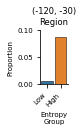

  entropy_group  count  matches      prop
0          High   1383    119.0  0.086045
1           Low   1687      9.0  0.005335
Hypothesis test comparing two independent proportions, two-sided, assuming binomial samples:
statistic = 10.367528907154497
pvalue = 3.484180800444075e-25
compare = diff
method = agresti-caffo
diff = 0.08070991603093025
ratio = 16.12862537157548
odds_ratio = 17.55291842475387
variance = 6.062233085129576e-05
alternative = two-sided
value = 0
tuple = (10.367528907154497, 3.484180800444075e-25)


Results for AATAAA in region (-30, 0)


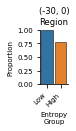

  entropy_group  count  matches      prop
0          High   1383   1075.0  0.777296
1           Low   1687   1678.0  0.994665
Hypothesis test comparing two independent proportions, two-sided, assuming binomial samples:
statistic = -19.14932420713803
pvalue = 9.805087159842254e-82
compare = diff
method = agresti-caffo
diff = -0.21736935203960706
ratio = 0.781464781352314
odds_ratio = 0.018720105877435965
variance = 0.00012863195523469807
alternative = two-sided
value = 0
tuple = (-19.14932420713803, 9.805087159842254e-82)


In [56]:
cleavage_heterogeneity.proportion_sites_with_motif(OUTDIR, gold_ent_single, ['AATAAA'], 'aataaa', (-120,-30), ylims = (0,0.1), ytickints=0.05)
cleavage_heterogeneity.proportion_sites_with_motif(OUTDIR, gold_ent_single, ['AATAAA'], 'aataaa', (-30,0), ylims = (0,1.0), ytickints=0.25)




Results for TTATTT,TTTTTC,TTTTCT,TTTCTT,TATTTT,TTTTAT,TTTTTA,TTCTTT,TTTTTT,TTTTGT,TTTATT,TTTGTT,TTTTTG,TGTTTT,TCTTTT,TTGTTT in region (0, 30)


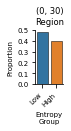

  entropy_group  count  matches      prop
0          High   1383    550.0  0.397686
1           Low   1687    811.0  0.480735
Hypothesis test comparing two independent proportions, two-sided, assuming binomial samples:
statistic = -4.630046458744256
pvalue = 3.6558369809245345e-06
compare = diff
method = agresti-caffo
diff = -0.08304884315901317
ratio = 0.8272461178677494
odds_ratio = 0.713182930385471
variance = 0.00032076638084883695
alternative = two-sided
value = 0
tuple = (-4.630046458744256, 3.6558369809245345e-06)


Results for TTATTT,TTTTTC,TTTTCT,TTTCTT,TATTTT,TTTTAT,TTTTTA,TTCTTT,TTTTTT,TTTTGT,TTTATT,TTTGTT,TTTTTG,TGTTTT,TCTTTT,TTGTTT in region (30, 50)


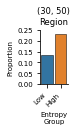

  entropy_group  count  matches      prop
0          High   1383    317.0  0.229212
1           Low   1687    225.0  0.133373
Hypothesis test comparing two independent proportions, two-sided, assuming binomial samples:
statistic = 6.836686652364079
pvalue = 8.104574304564821e-12
compare = diff
method = agresti-caffo
diff = 0.09583900706392853
ratio = 1.7185795774082109
odds_ratio = 1.9322659995830729
variance = 0.00019633716192638852
alternative = two-sided
value = 0
tuple = (6.836686652364079, 8.104574304564821e-12)


In [37]:
cleavage_heterogeneity.proportion_sites_with_motif(OUTDIR, gold_ent_single, t_rich, 't_rich', (0,30), ylims = (0,0.5), ytickints=0.1)
cleavage_heterogeneity.proportion_sites_with_motif(OUTDIR, gold_ent_single, t_rich, 't_rich', (30,50), ylims = (0,0.25), ytickints=0.05)




Results for TTCTGG,TGTCCT,TGTGTC,GTTGTG,GTTGTC,GTGTTA,TCTGTC,TTTGTG,CCGTCT,ATTCTG,CTGTCT,ATGTCT,ATGTGG,CCCTGT,TGTGAG,GGTGTG,CTGTTC,TGTGGG,GGTGTT,CGTCTC,TTCTGC,CGTCTT,GTGTCT,CTGTCC,AGTGTG,TCTGGG,TGTCTT,GTCTTT,GTGTGT,GTGTTC,TAGTGT,AGTGTT,GTCTGT,AGTCTT,TGTCGT,GTGTTG,ATTGTC,CCTGTT,GTCTAT,TCTGCC,TCTGGT,GTCTGG,TGTGCG,TGTGTT,CTTGTG,TGTGAT,GTCTTA,GTGTGA,TTGTGG,TTGTGA,GTTCTG,TGTCCC,CTGTGT,GCTGTG,TTGTCC,GAGTGT,CGTGTG,TGGTCT,TTGTGC,GTCTCC,TGTGGA,CTTGTC,GTCTTG,CCTCTG,TATCTG,TGTGTG,TACTGT,TATGTG,TTCTGT,CCTGTC,GGTCTG,GCGTGT,GGCTGT,ATTGTG,TCTGAT,CTGTTT,TGTCTA,GATGTG,TTGTGT,CGTGTT,TTTGTC,TCTCTG,GTGTTT,CTGTGG,GTCTTC,ACTGTT,GGTCTT,GTGTGC,GTGTGG,CTGTTG,TGTGGC,TGCTGT,TGGTGT,TTCTGA,TCTGTG,CTCTGC,GTCTCT,TCTGTT,TCCTGT,CTCTGT,TGTGGT,GGTGTC,ATGTGT,TGTCAT,GGGTCT,TTTCTG,GCTGTT,AGGTGT,TCGTGT,TGTCTG,CTTCTG,TAGTCT,TTGTCA,ATCTGT,TCGTCT,TCTGCT,TTGTCT,TGTCTC,GGGTGT,TATGTC,CTGTTA,TGTGCT in region (0, 20)


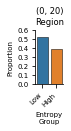

  entropy_group  count  matches      prop
0          High   1383    538.0  0.389009
1           Low   1687    886.0  0.525193
Hypothesis test comparing two independent proportions, two-sided, assuming binomial samples:
statistic = -7.610835501647213
pvalue = 2.7232966254320202e-14
compare = diff
method = agresti-caffo
diff = -0.13618324981859065
ratio = 0.7406984848262276
odds_ratio = 0.5756047390706185
variance = 0.00031927826326984537
alternative = two-sided
value = 0
tuple = (-7.610835501647213, 2.7232966254320202e-14)


Results for TTCTGG,TGTCCT,TGTGTC,GTTGTG,GTTGTC,GTGTTA,TCTGTC,TTTGTG,CCGTCT,ATTCTG,CTGTCT,ATGTCT,ATGTGG,CCCTGT,TGTGAG,GGTGTG,CTGTTC,TGTGGG,GGTGTT,CGTCTC,TTCTGC,CGTCTT,GTGTCT,CTGTCC,AGTGTG,TCTGGG,TGTCTT,GTCTTT,GTGTGT,GTGTTC,TAGTGT,AGTGTT,GTCTGT,AGTCTT,TGTCGT,GTGTTG,ATTGTC,CCTGTT,GTCTAT,TCTGCC,TCTGGT,GTCTGG,TGTGCG,TGTGTT,CTTGTG,TGTGAT,GTCTTA,GTGTGA,TTGTGG,TTGTGA,GTTCTG,TGTCCC,CTGTGT,GCTGTG,TTGTCC,GAGTGT,CGTGTG,TGGTCT,TTGTGC,GTCTCC,TGTGGA,CTTGTC,GTCTTG,CCTCTG,TATCTG,TGT

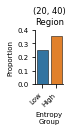

  entropy_group  count  matches      prop
0          High   1383    493.0  0.356471
1           Low   1687    418.0  0.247777
Hypothesis test comparing two independent proportions, two-sided, assuming binomial samples:
statistic = 6.535766080295528
pvalue = 6.328476173621912e-11
compare = diff
method = agresti-caffo
diff = 0.1086943197545262
ratio = 1.438677792884894
odds_ratio = 1.6816757163593357
variance = 0.00027611498150587044
alternative = two-sided
value = 0
tuple = (6.535766080295528, 6.328476173621912e-11)


In [38]:
cleavage_heterogeneity.proportion_sites_with_motif(OUTDIR, gold_ent_single, gt_rich, 'gt_rich', (0,20), ylims = (0,0.6), ytickints=0.1)
cleavage_heterogeneity.proportion_sites_with_motif(OUTDIR, gold_ent_single, gt_rich, 'gt_rich', (20,40), ylims = (0,0.4), ytickints=0.1)


## AAUAAA - U-rich and GU/CU-rich distances by entropy group


In [39]:
gold_aataaa = gold_ent_single.copy()
gold_aataaa['aataaa_idx'] = gold_aataaa.apply(lambda row: np.max(classification_cleavage.count_motifs(row['sequence'][:row['max_cleavage']], ['AATAAA'], method = 'priority', overlapping = False, preference = 'max', count_only = False, index_only = True)), axis = 1)


### Measure Existing Distances


#### U-Rich Motifs

In [40]:
gold_aataaa_trich = gold_aataaa.loc[gold_aataaa.apply(lambda row: any([m in row['sequence'][row['max_cleavage']:] for m in t_rich]), axis = 1)].copy()
gold_aataaa_trich['trich_idx'] = gold_aataaa_trich.apply(lambda row: row['max_cleavage'] + np.min(classification_cleavage.count_motifs(row['sequence'][row['max_cleavage']:], t_rich, method = 'sequential', preference = 'min', overlapping = False, count_only = False, index_only = True)), axis = 1)
gold_aataaa_trich['trich_distance'] = gold_aataaa_trich['trich_idx'] - gold_aataaa_trich['aataaa_idx']

print(gold_aataaa.shape)
print(gold_aataaa_trich.shape)


(3070, 57)
(2208, 59)


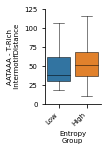

Low     1178
High    1030
Name: entropy_group, dtype: int64
               count       mean  median        std
entropy_group                                     
High            1030  57.419417      51  27.847858
Low             1178  49.668081      38  28.377106

Wilcoxon Rank Sum Test Comparing Low vs High Groups:
RanksumsResult(statistic=-9.680638528742996, pvalue=3.6443269836148453e-22)


In [41]:
fig,ax = plt.subplots(1,1, figsize = (1,1.75))

sns.boxplot(data = gold_aataaa_trich, 
            x = 'entropy_group', y = 'trich_distance', showfliers = False,
            boxprops = {'edgecolor' : 'black', 'linewidth' : 0.5},
            medianprops = {'color' : 'black', 'linewidth' : 0.5},
            whiskerprops = {'color' : 'black', 'linewidth' : 0.5},
            capprops = {'color' : 'black', 'linewidth' : 0.5},
            flierprops = {'color' : 'black'},
            ax = ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right')

ax.set_xlabel("Entropy\nGroup")
ax.set_ylabel("AATAAA - T-Rich\n IntermotifDistance")

ax.set_ylim(0,125)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'aataaa_trich_distance_boxplot.svg'), format = 'svg', dpi = 600, transparent = True)    
plt.show()


print(gold_aataaa_trich.entropy_group.value_counts())

print(gold_aataaa_trich.groupby('entropy_group')['trich_distance'].agg(['count','mean','median','std']))

print(f"\nWilcoxon Rank Sum Test Comparing Low vs High Groups:")
print(st.ranksums(gold_aataaa_trich.loc[gold_aataaa_trich['entropy_group'] == 'Low', 'trich_distance'],
                  gold_aataaa_trich.loc[gold_aataaa_trich['entropy_group'] == 'High', 'trich_distance']))



#### GU/CU-Rich Motifs

In [42]:
gold_aataaa_gtrich = gold_aataaa.loc[gold_aataaa.apply(lambda row: any([m in row['sequence'][row['max_cleavage']:] for m in gt_rich]), axis = 1)].copy()
gold_aataaa_gtrich['gtrich_idx'] = gold_aataaa_gtrich.apply(lambda row: row['max_cleavage'] + np.min(classification_cleavage.count_motifs(row['sequence'][row['max_cleavage']:], gt_rich, method = 'sequential', preference = 'min', overlapping = False, count_only = False, index_only = True)), axis = 1)
gold_aataaa_gtrich['gtrich_distance'] = gold_aataaa_gtrich['gtrich_idx'] - gold_aataaa_gtrich['aataaa_idx']

print(gold_aataaa.shape)
print(gold_aataaa_gtrich.shape)


(3070, 57)
(2774, 59)


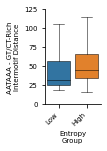

Low     1528
High    1246
Name: entropy_group, dtype: int64
               count       mean  median        std
entropy_group                                     
High            1246  53.968700    45.0  28.963705
Low             1528  45.475785    31.5  28.698362

Wilcoxon Rank Sum Test Comparing Low vs High Groups:
RanksumsResult(statistic=-11.860694131223966, pvalue=1.8939841887326663e-32)


In [43]:
fig,ax = plt.subplots(1,1, figsize = (1,1.75))

sns.boxplot(data = gold_aataaa_gtrich, 
            x = 'entropy_group', y = 'gtrich_distance', showfliers = False,
            boxprops = {'edgecolor' : 'black', 'linewidth' : 0.5},
            medianprops = {'color' : 'black', 'linewidth' : 0.5},
            whiskerprops = {'color' : 'black', 'linewidth' : 0.5},
            capprops = {'color' : 'black', 'linewidth' : 0.5},
            flierprops = {'color' : 'black'},
            ax = ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right')

ax.set_xlabel("Entropy\nGroup")
ax.set_ylabel("AATAAA - GT/CT-Rich\nIntermotif Distance")

ax.set_ylim(0,125)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'aataaa_gtrich_distance_boxplot.svg'), format = 'svg', dpi = 600, transparent = True)    
plt.show()


print(gold_aataaa_gtrich.entropy_group.value_counts())

print(gold_aataaa_gtrich.groupby('entropy_group')['gtrich_distance'].agg(['count','mean','median','std']))

print(f"\nWilcoxon Rank Sum Test Comparing Low vs High Groups:")
print(st.ranksums(gold_aataaa_gtrich.loc[gold_aataaa_gtrich['entropy_group'] == 'Low', 'gtrich_distance'],
                  gold_aataaa_gtrich.loc[gold_aataaa_gtrich['entropy_group'] == 'High', 'gtrich_distance']))


## Alter Distances and Observe Effect on Cleavage Entropy

In [44]:
MOTDIR = os.path.join(PROJECT,'model','motif_removal')

#### Subset Sites with Various AATAAA - Rich Distances

In [57]:
gold_aataaa_trich['pasID'] = gold_aataaa_trich.apply(lambda row: f'{int(row.name):06d}:{row.chrom}:{row.start}:{row.strand}', axis = 1)

condL1 = (gold_aataaa_trich['entropy_group'] == 'Low')
condL2 = (gold_aataaa_trich['trich_distance'].between(20,40))

condH1 = (gold_aataaa_trich['entropy_group'] == 'High')
condH2 = (gold_aataaa_trich['trich_distance'].between(40,100))

gold_aataaa_trich_close = gold_aataaa_trich.loc[condL1 & condL2].copy()
gold_aataaa_trich_far   = gold_aataaa_trich.loc[condH1 & condH2].copy()

print(gold_aataaa_trich_close.shape)
print(gold_aataaa_trich_far.shape)

outcol = ['pasID','sequence','entropy_group','aataaa_idx','trich_idx','trich_distance']

gold_aataaa_trich_close[outcol].to_csv(os.path.join(MOTDIR, 'cleavage_distances_redist', 'aataaa_trich_close.txt'), sep = "\t", index = False)
gold_aataaa_trich_far[outcol].to_csv(os.path.join(MOTDIR, 'cleavage_distances_redist', 'aataaa_trich_far.txt'), sep = "\t", index = False)


(676, 59)
(635, 59)


In [58]:
gold_aataaa_gtrich['pasID'] = gold_aataaa_gtrich.apply(lambda row: f'{int(row.name):06d}:{row.chrom}:{row.start}:{row.strand}', axis = 1)

condL1 = (gold_aataaa_gtrich['entropy_group'] == 'Low')
condL2 = (gold_aataaa_gtrich['gtrich_distance'].between(20,40))

condH1 = (gold_aataaa_gtrich['entropy_group'] == 'High')
condH2 = (gold_aataaa_gtrich['gtrich_distance'].between(40,100))

gold_aataaa_gtrich_close = gold_aataaa_gtrich.loc[condL1 & condL2].copy()
gold_aataaa_gtrich_far   = gold_aataaa_gtrich.loc[condH1 & condH2].copy()

print(gold_aataaa_gtrich_close.shape)
print(gold_aataaa_gtrich_far.shape)

outcol = ['pasID','sequence','entropy_group','aataaa_idx','gtrich_idx','gtrich_distance']

gold_aataaa_gtrich_close[outcol].to_csv(os.path.join(MOTDIR, 'cleavage_distances_redist', 'aataaa_gtrich_close.txt'), sep = "\t", index = False)
gold_aataaa_gtrich_far[outcol].to_csv(os.path.join(MOTDIR, 'cleavage_distances_redist', 'aataaa_gtrich_far.txt'), sep = "\t", index = False)


(949, 59)
(658, 59)


#### Load Results from Modulating Distances

Parameters:
	Motif group = T-Rich
	Distance group = close
	Moving = both
(676, 6)


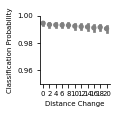

Kruskal-Wallis H-Test for Independent Samples for Classification Probability:
KruskalResult(statistic=24.057836111598842, pvalue=0.007448347205729629)


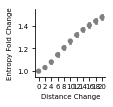

Kruskal-Wallis H-Test for Independent Samples for Cleavage Vector Entropy:
KruskalResult(statistic=3386.677330278409, pvalue=0.0)


In [47]:
cleavage_heterogeneity.process_cleavage_distances(MOTDIR, OUTDIR, 'T-Rich', 'close', 'both', class_ylims = (0.95,1), entropy_ylims = (0.95,1.55))


Parameters:
	Motif group = T-Rich
	Distance group = far
	Moving = both
(635, 6)


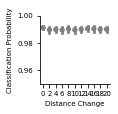

Kruskal-Wallis H-Test for Independent Samples for Classification Probability:
KruskalResult(statistic=2.1444671843776613, pvalue=0.995108173502705)


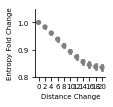

Kruskal-Wallis H-Test for Independent Samples for Cleavage Vector Entropy:
KruskalResult(statistic=1737.3342339082203, pvalue=0.0)


In [48]:
cleavage_heterogeneity.process_cleavage_distances(MOTDIR, OUTDIR, 'T-Rich', 'far', 'both', class_ylims = (0.95,1), entropy_ylims = (0.8,1.05))


Parameters:
	Motif group = GT-Rich
	Distance group = close
	Moving = both
(949, 6)


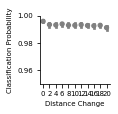

Kruskal-Wallis H-Test for Independent Samples for Classification Probability:
KruskalResult(statistic=58.30264402888573, pvalue=7.581294955073928e-09)


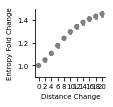

Kruskal-Wallis H-Test for Independent Samples for Cleavage Vector Entropy:
KruskalResult(statistic=4474.621491155153, pvalue=0.0)


In [49]:
cleavage_heterogeneity.process_cleavage_distances(MOTDIR, OUTDIR, 'GT-Rich', 'close', 'both', class_ylims = (0.95,1), entropy_ylims = (0.9,1.5))


Parameters:
	Motif group = GT-Rich
	Distance group = far
	Moving = both
(658, 6)


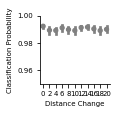

Kruskal-Wallis H-Test for Independent Samples for Classification Probability:
KruskalResult(statistic=2.30044222211374, pvalue=0.993475825848273)


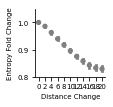

Kruskal-Wallis H-Test for Independent Samples for Cleavage Vector Entropy:
KruskalResult(statistic=1852.2054058057215, pvalue=0.0)


In [50]:
cleavage_heterogeneity.process_cleavage_distances(MOTDIR, OUTDIR, 'GT-Rich', 'far', 'both', class_ylims = (0.95,1), entropy_ylims = (0.8,1.05))
